In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import re

# DXT Darshan logs

Darshan logs do not use tabs to separate fields but this script requires it. To transform multiple spaces into tabs use:

`sed -i 's/ \+ /\t/g' *.dxt.log`

In [2]:
application_name = "nwchem"
postfix_name = ""
darshan_file = "../%s/darshan/%s%s.dxt.log" %(application_name, application_name, postfix_name)

## Read the Darshan log

In [3]:
def get_accessed_files(file):
    inf = open(file)
    file_list = []
    cfile = 0
    for line in inf:
        if "DXT, file_id:" in line:
            cfile = line[50:-1]
        if "DXT, write_count:" in line:
            access_cnt = sum([int(i) for i in re.findall(r'\d+', line)])
            file_list += [cfile] * access_cnt
    inf.close()
    return file_list

In [4]:
df = pd.read_csv(darshan_file, delimiter='\t', comment='#',
                 names=["Module", "Rank", "IOType", "Segment", "Offset",
                        "Length", "Start", "End"])
# Add information about the added files
df["File"] = get_accessed_files(darshan_file)
# Filter out entries with length 0
df = df[df.Length > 0]
df.head()

,Module,Rank,IOType,Segment,Offset,Length,Start,End,File
0,X_POSIX,0,read,0,0,269,0.0475,0.0475,pfs/alpine/csc143/proj-shared/againaru/nwchem/...
3,X_POSIX,0,read,3,0,269,0.1280,0.1280,pfs/alpine/csc143/proj-shared/againaru/nwchem/...
6,X_POSIX,0,read,6,0,269,0.3202,0.3202,pfs/alpine/csc143/proj-shared/againaru/nwchem/...
9,X_POSIX,0,read,0,0,3425,0.2738,0.2738,gpfs/alpine/csc143/proj-shared/againaru/nwchem...
11,X_POSIX,0,read,0,0,8192,0.4403,0.4420,pfs/alpine/csc143/proj-shared/againaru/nwchem/...


In [5]:
# Unique files and number of accesses
df.groupby(['File', 'IOType'])["Module"].count()

File                                                                                             IOType
fs/alpine/csc143/proj-shared/againaru/nwchem/summit_submit/copro_md_trj_dump.bp/data.2           write     42000
gpfs/alpine/csc143/proj-shared/againaru/nwchem/summit_submit/adios2.xml                          read          1
gpfs/alpine/csc143/proj-shared/againaru/nwchem/summit_submit/copro.top                           read        408
gpfs/alpine/csc143/proj-shared/againaru/nwchem/summit_submit/copro_md.trj                        write        58
gpfs/alpine/csc143/proj-shared/againaru/nwchem/summit_submit/copro_md_trj_dump.bp/data.3         write     42000
gpfs/alpine/csc143/proj-shared/againaru/nwchem/summit_submit/copro_md_trj_dump.bp/data.4         write     42000
pfs/alpine/csc143/proj-shared/againaru/nwchem/summit_submit/copro.nw                             read          3
pfs/alpine/csc143/proj-shared/againaru/nwchem/summit_submit/copro_md.out                         write   

In [6]:
# Number of ranks accessing the storage
print("Total ranks", max(df.Rank))
len(df.Rank.unique())

Total ranks 210


6

In [7]:
# Total amount of time doing IO to total execution time
print("%.5f s in IO out of %.2f s execution time (perc %.3f)" %(sum(df["End"] - df["Start"]),
                                                                 max(df.End),
                                                                 sum(df["End"] - df["Start"]) * 100 /max(df.End)))

8.91150 s in IO out of 175.68 s execution time (perc 5.073)


In [8]:
# filtering functions
def filter_by_filename(df, filter_file):
    if filter_file:
        return df[df['File'].str.contains(filter_file)]
    return df

def filter_by_timeframe(df, timeframe):
    return df[(df.Start > timeframe[0]) & (df.End < timeframe[1])]

# Plot the IO pattern

In [9]:
df_temp = df[df['File'].str.contains("copro")]

In [10]:
def plot_heatmap(df, type_aggregation="count", filter_file=False, save=False):
    df_temp = filter_by_filename(df, filter_file)
    # for now we limit the number of segments to 3k
    if type_aggregation == "sum":
        df_temp = df_temp[df_temp.Segment<3000].groupby(['Rank','Segment'])["Length"].sum()
    else:
        # by default the function will use count
        df_temp = df_temp[df_temp.Segment<3000].groupby(['Rank','Segment'])["Length"].count()
    df_temp = df_temp.unstack(level=0)
    sns.set(font_scale=2)
    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(10,20))
    sns.heatmap(df_temp)
    if save:
        plt.savefig("%s%s_rankseg.png" %(application_name, postfix_name),
                    bbox_inches = 'tight')

## Amount and count of segment accesses done by every rank
    # filter by all files containing the word copro

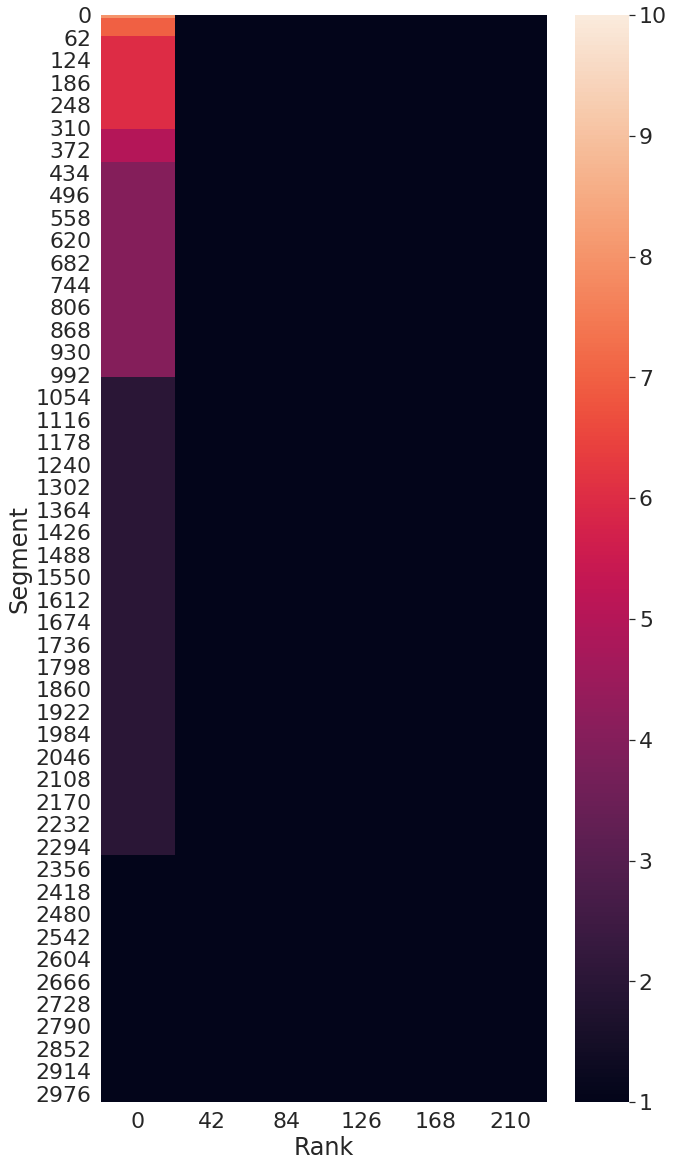

In [11]:
plot_heatmap(df, type_aggregation="count", filter_file='copro', save=False)

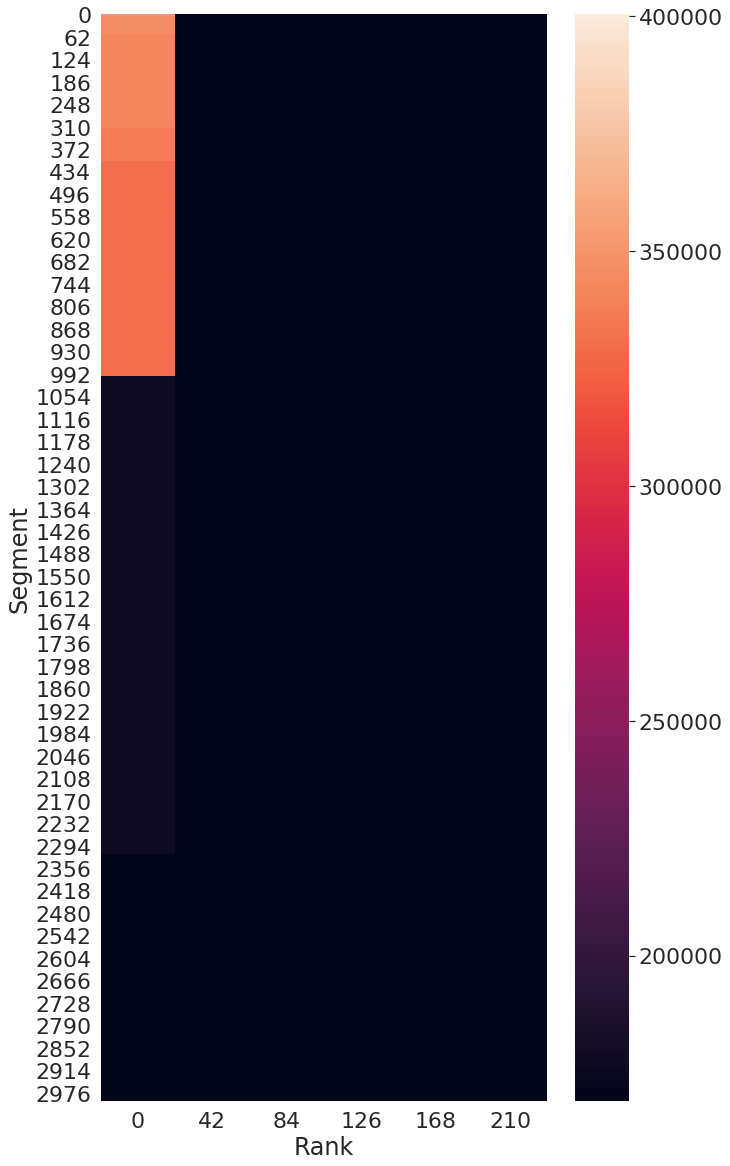

In [12]:
plot_heatmap(df, type_aggregation="sum", filter_file='copro', save=False)

## Plot the Read / Writes for each rank in time

In [33]:
def plot_io_per_rank(df_filter, scale, timeframe, save):
    sns.set(font_scale=2)
    sns.set_style("white")
    fig, ax = plt.subplots(figsize=(20,len(df.Rank.unique())))
    plt.axes()
    plt.gca().set_xlim(timeframe[0], timeframe[1])
    plt.gca().set_ylim(0, len(df.Rank.unique()))
    
    # Generate the association between rank number and its index in the plot
    rank_index = {}
    cnt = 0
    for i in df_filter.Rank.unique():
        rank_index[i] = cnt
        cnt += 1

    # Generate random colors for each file
    color = {}
    patch = []
    for i in df_filter.File.unique():
        color[i] = np.random.rand(3)
        patch.append(mpatches.Patch(color=color[i], label=i))
        plt.legend(handles=patch, bbox_to_anchor=(1.05, 1), loc='upper left')

    # plot the pattern
    cnt = {i:0 for i in rank_index}
    max_end = 0
    for i in df_filter[["Rank", "File", "Start", "End", "IOType"]].values:
        # filter at 5k accesses for all ranks
        if cnt[i[0]] > 1000:
            continue
        start = i[2]
        end = i[3]
        if end > max_end:
            max_end = end
        rank = rank_index[i[0]]
        if i[4] == "write":
            rectangle = plt.Rectangle((start, rank), max(1, (end - start) * scale),
                                      1, fc=color[i[1]], hatch="/")
        else:
            rectangle = plt.Rectangle((start, rank), max(1, (end - start) * scale),
                                      1, fc=color[i[1]])
        plt.gca().add_patch(rectangle)
        cnt[i[0]] += 1
        if all(cnt[k]>1000 for k in cnt):
            print("Warning, data exceeds 1000 IO accesses per rank. Plotting only the first 1000 accesses for each rank !")
            plt.gca().set_xlim(timeframe[0], end)
            break

    plt.gca().set_xlabel('Time')
    plt.gca().set_ylabel('Rank')
    plt.gca().set_title("%s%s" %(application_name.capitalize(), postfix_name))
    if save:
        plt.savefig("%s%s_dxt.png" %(application_name, postfix_name),
                    bbox_inches = 'tight')
    plt.show()

def profile_IOtime_rank(df, filter_file=False, filter_time=False, save=False):
    # prepare data
    if filter_file:
        df_filter = filter_by_filename(df, filter_file)
    else:
        df_filter = df
    timeframe = [0, max(df_filter.End)]
    if filter_time:
        timeframe = filter_time
        df_filter = filter_by_timeframe(df_filter, timeframe)
    
    # scale IO so that it represents at least 10 % of the total time
    perc_io = sum(df["End"] - df["Start"]) * 100 /max(df.End)
    scale = 1
    if perc_io < 1:
        scale = 10 / perc_io
        
    plot_io_per_rank(df_filter, scale, timeframe, save)

### Detailed plot of IO accesses and duration 

- Amounts lower than 0 seconds are rounded up to 1
- If the IO time is less than 10% of total execution time, the IO is scaled up to represent 10%

Warning, data exceeds 1000 IO accesses per rank. Plotting only the first set!


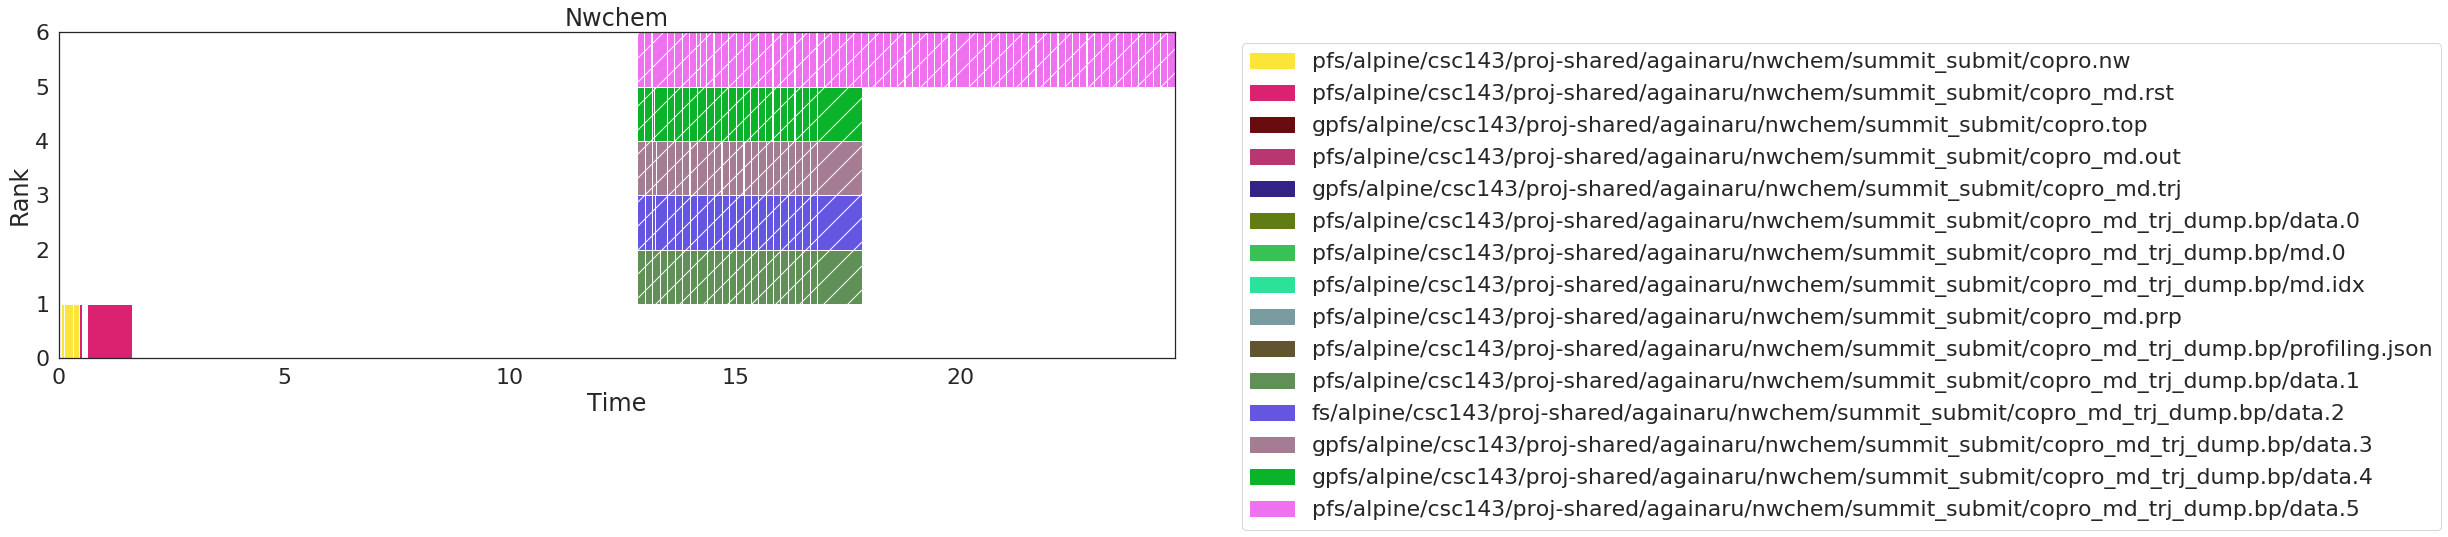

In [32]:
profile_IOtime_rank(df, filter_file="copro")

Warning, data exceeds 1000 IO accesses per rank. Plotting only the first set!


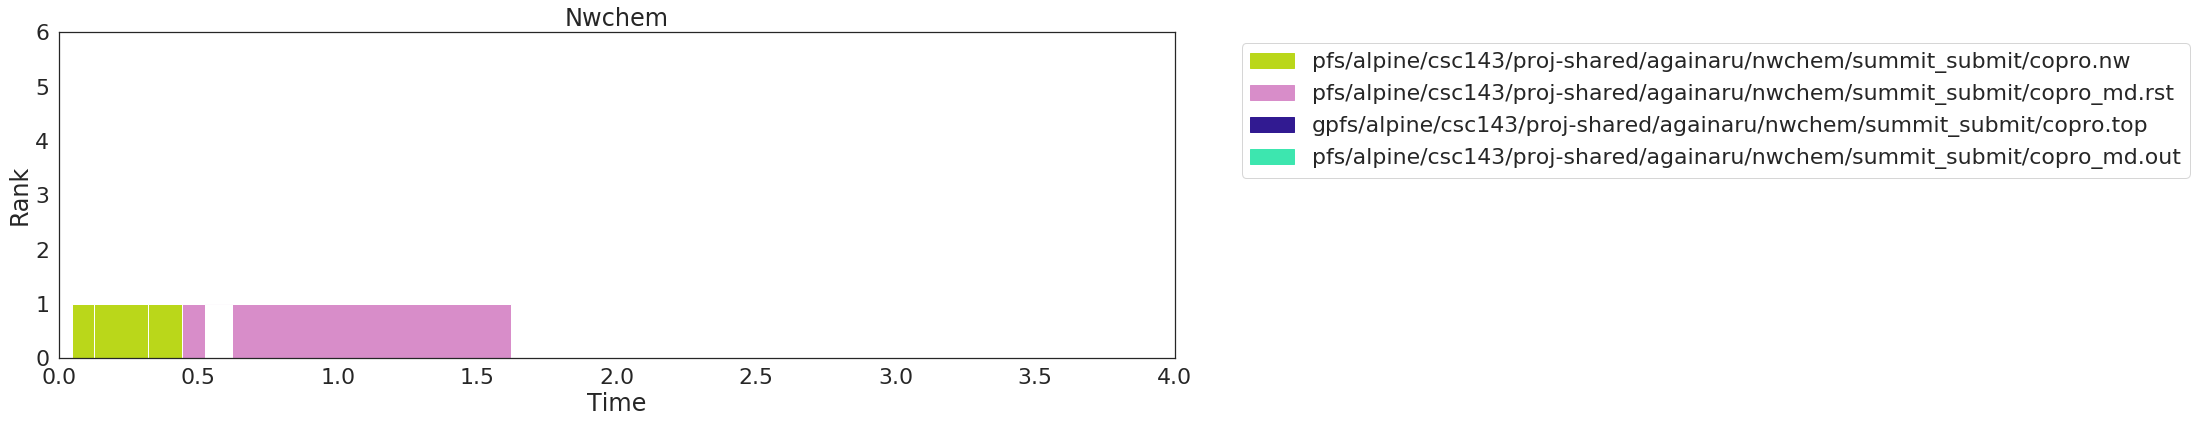

In [30]:
profile_IOtime_rank(df, filter_file="copro", filter_time=[0,4])

### Aggregated plot of IO accesses per file per rank
- Rank i will access file f from start to end (start = first access, end = last access)

In [16]:
df_temp = df.groupby(['Rank','File','IOType']).agg({'Start':'min', 'End':'max'})[['Start','End']].reset_index()

In [17]:
df_temp

,Rank,File,IOType,Start,End
0,0,gpfs/alpine/csc143/proj-shared/againaru/nwchem...,read,0.2738,0.2738
1,0,gpfs/alpine/csc143/proj-shared/againaru/nwchem...,read,0.6433,1.1408
2,0,gpfs/alpine/csc143/proj-shared/againaru/nwchem...,write,12.7640,175.5483
3,0,pfs/alpine/csc143/proj-shared/againaru/nwchem/...,read,0.0475,0.3202
4,0,pfs/alpine/csc143/proj-shared/againaru/nwchem/...,write,0.6477,175.5482
5,0,pfs/alpine/csc143/proj-shared/againaru/nwchem/...,write,12.9545,175.5485
6,0,pfs/alpine/csc143/proj-shared/againaru/nwchem/...,read,0.4403,1.0187
7,0,pfs/alpine/csc143/proj-shared/againaru/nwchem/...,write,12.8269,175.3886
8,0,pfs/alpine/csc143/proj-shared/againaru/nwchem/...,write,12.8310,175.3892
9,0,pfs/alpine/csc143/proj-shared/againaru/nwchem/...,write,12.8312,175.6772


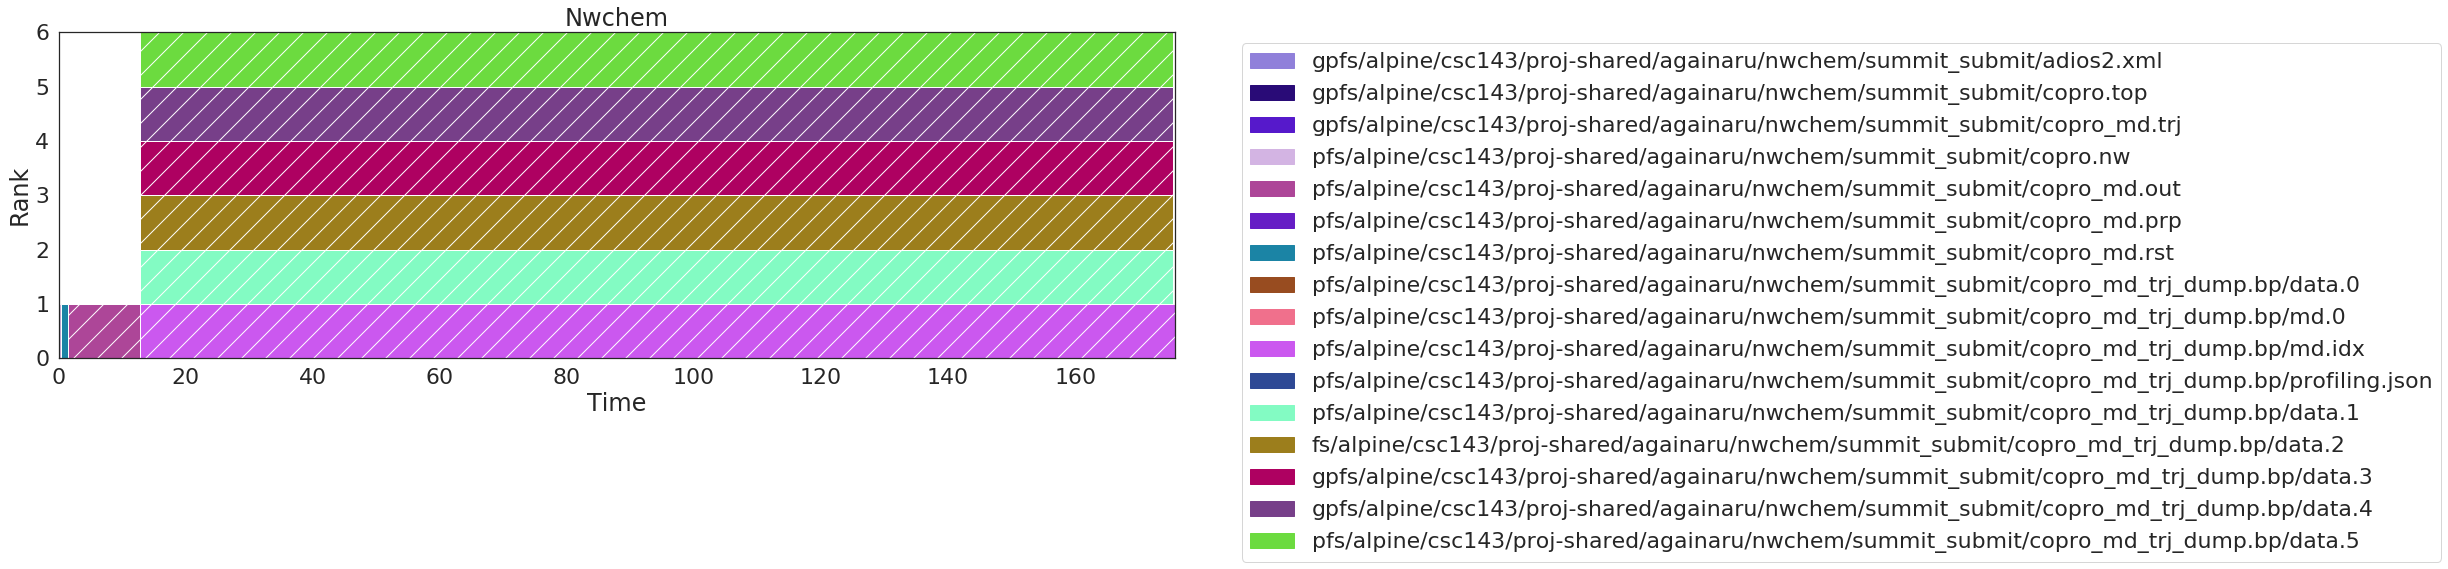

In [18]:
profile_IOtime_rank(df_temp)